In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import eig
import nlpde_utils

# Explanation

This notebook contains the example code for the fitting procedure we used to obtain $\bar\alpha$ for each bar.

- The fitting interval is 50 frames starting from a 'reference frame', which corresponds to 200 minutes after plating (this is not the same for each experimentald day). This is considered the initial patterning regime.
- Experimental time is scaled by a timescale $\tau = 35^2 / 3$ minutes and space by $35$ micron, *for all experiments*, to go to scaled units.
- The bars of length 40µm are left out (they are not rectangles, and the domain is too small to pattern). The very long bars in the dataset are also not used in this paper

### Determining $\bar\alpha$

As also described in the supplemental materials, we do the following. We scan over $\bar\alpha$. For each value, we compute the eigenvalues $\omega_n$ and modes $u_n$ (they depend on $\ell$ and $\bar\alpha$). We do this using a direct numerical method, so not the analytically exact one (see also the other notebook on the eigenvalues and eigenmodes). 
Next, we compute coefficients $c_n$ that yield the best approximation 
$$ \sum_n c_n u_n(x) e^{\omega_n t}$$
to the experimentally observed $\rho(x, t)$. Of course the experimental data is discretized at spatial points $\hat x_i$ and timepoints $\hat t_j$, (hats mean we normalized the units) so we choose the $c_n$ as the minimizing coefficients of 
$$E(\bar\alpha)= \sum_{i,j,k}\left(c_k e^{\omega_k \hat t_j} u_k(\hat x_i) - \rho_{i,j}\right)^2. $$
The minimization is done using least-squares. We then keep the error $E(\bar\alpha)$, for each value of $\bar\alpha$, and in the end pick the $\bar\alpha$ that gives the smallest error. 

### Notes
- We substract the mean from the experimental density profile, per timepoint. This is because the linearized equation describes deviations $\rho -\rho_0$. In the experiment, the average density is not constant over time, which is why we do the substraction per timepoint.
- We adapt the number of spatial modes we compute depending on the length of the bar. This is because we also have a different number of spatial points depending on the bar length. 

In [2]:
### Load in the descriptors of the bar data
allbardata = pd.read_csv("data/bardata_allexperiments_extended.csv")

#### experiment and bar labels as strings
allbardata['Experiment'] = allbardata['Experiment'].astype(str)
allbardata['Bar'] = allbardata['Bar'].astype(str)
allbardata.set_index(['Experiment', 'Bar'], inplace=True)

###### get the intended printed length (these are multiples of 10 micron. The 1.084 comes from the resolution of the image (pixels per micron))
allbardata['Length_micron'] = np.round((allbardata['Length']/1.084/20))*20

##### drop the square bars and the very long ones
allbardata.drop( allbardata.index[allbardata['Length_micron']==40], inplace=True)
allbardata.drop( allbardata.index[allbardata['Length_micron']>330], inplace=True)

#### Load in all the density profiles
### and do light processing (smoothing)
avgn = 11 # averaging window

density_profiles = {}
for exp, bar in allbardata.index:
    filename = f'data/bars_density_profiles/{exp}_bar{bar}_threxp_densityhigh_n.txt'
    xrho = np.loadtxt(filename) ## first row: x values, the rest is density per timepoint
    x = xrho[0]
    rho = xrho[1:]
    rho_smooth = np.zeros_like(rho)

    for i in range(rho.shape[1]): #### iterate over spatial positions
        rh_extended = np.hstack((avgn//2 * [rho[0,i]], rho[:,i], avgn//2 * [rho[-1,i]]))
        rho_smooth[:,i] = np.convolve(rh_extended, np.ones(avgn)/avgn, mode='same')[avgn//2: - avgn//2+1]

    ### save to dictionary
    density_profiles[(exp,bar)] = (x,rho,rho_smooth)



In [3]:
## functions
def get_eva_eve(alphabar, L, xd, n):
    """ returns eigenvalues and eigenvectors for given L and alphabar. also interpolates to xd instead of Cheby grid.
    Returns n eigenvalue/vector pairs: the n with largest real part of the eigenvalue.
    """
    def g(x):
        return np.exp(-x)
    N = 50 # there will be N+1 differentiation points
    
    # matrices
    D, x = nlpde_utils.cheb(N)
    x = (x+1)*L/2
    D *= 2/L
    
    A0 = nlpde_utils.get_A_cheb(x, g, L, 'clencurt')
    
    M1 = D-alphabar*A0
    # boundary conditions
    M = D@M1
    M[0,:] = M1[0,:]
    M[-1,:] = M1[-1,:]
    B = np.eye(M.shape[0])
    B[0,:]=0
    B[-1,:]=0
    
    # now solve the generalized EV problem A v = omega B v
    # the final matrix
    eival, eivec = eig(M,B)
    # remove infinity
    idxinf = np.isinf(eival)
    eival = eival[~idxinf]
    eivec = eivec[:,~idxinf]

    # order from high to low
    idxsort = np.argsort(eival)[-1::-1]
    eival=eival[idxsort]
    eivec=eivec[:,idxsort]

    ## interpolate to other spatial grid
    eivec_eqspaced=  np.zeros((len(xd), eivec.shape[1]))
    for i in range(eivec.shape[1]):
        eivec_eqspaced[:,i] = np.interp(xd, x[-1::-1], eivec[-1::-1,i])
        # normalize
        eivec_eqspaced[:,i] /= np.sqrt(np.sum(eivec_eqspaced[:,i]**2))

    # select up to n
    eivec_eqspaced = eivec_eqspaced[:, :n]
    eival = eival[:n]

    return eival, eivec_eqspaced

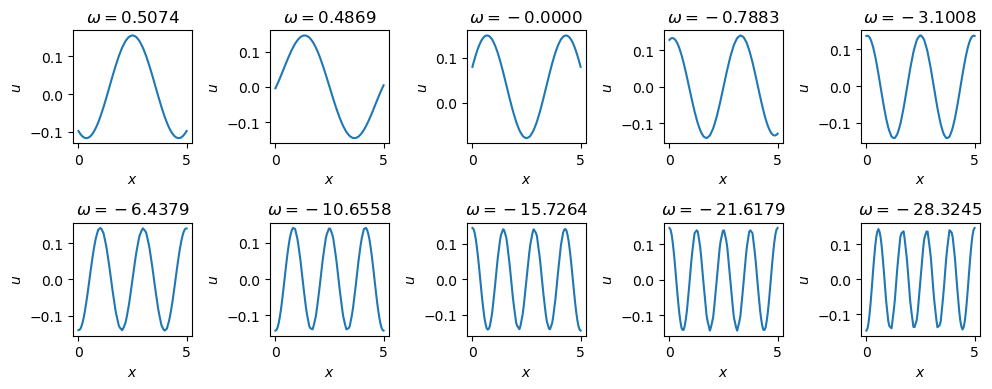

In [4]:
### test
L = 5
alphabar = 2

x = np.linspace(0, L, 100)

omega, u = get_eva_eve(alphabar, L, x, n=10)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    ax = axes.flatten()[i]
    ax.plot(x, u[:, i])
    ax.set_title(r"$\omega = {:.4f}$".format(omega[i].real))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u$")
fig.tight_layout()

In [22]:
#### Functions for the fit
dt=5
delta_interval = 50 ## how many frames we use


def get_coefficients_and_approximation(X, x, alphabar, tau, L, sigma, nmodes=6):
    """ X has the profiles in each row (row=timepoint)
     x is spatial points. 
     This function computes the coefficients such that the linear solution is close to the experimental data"""

    #### compute the eigenvalues/vectors
    eva, eve = get_eva_eve(alphabar, L/sigma, x/sigma, nmodes)
    eva = eva.real # to get rid of errors, but all eigenvalues should be real
    
   
    ## compute the best exponential fit
    ntimepoints=X.shape[0]

    #### Least squares on the full time evolution
    ### calculate the coefficients, based on global fit to time evolution
    A2 = np.zeros((ntimepoints * len(x), nmodes))
    for i in range(ntimepoints):
        for m in range(nmodes):
            A2[i*len(x): (i+1)*len(x), m] = eve[:,m] * np.exp(i*dt*eva[m]/tau)
            
    ## fit the coefficients for each mode
    cv = np.linalg.lstsq(A2, X.flatten(), rcond=None)[0]
    ## calculate reconstructed density
    X_rec = (A2 @ cv).reshape(X.shape)

    ############## in addition, we also compute the coefficients per frame
    c_fitted = np.linalg.lstsq(eve, X.T, rcond=None)[0] # time axis is second axis
    c_fitted = c_fitted.T # time along zero axis now

    ### coefficient evolution over time from the global fit
    #### matrix with in each column e^(omega_i t/tau) for i in 0..nmodes-1
    A = np.zeros((ntimepoints, nmodes))
    for i in range(nmodes):
        A[:, i] = np.exp(eva[i]*np.arange(ntimepoints)*dt/tau)
        
    c_rec = A@ np.diag(cv)
    return c_fitted,X_rec, c_rec
    
def get_error(X, x, alphabar, tau, L, sigma, nmodes):
    """ X contains the values of rho (minus the mean). x is the space points
     tau is time rescaling to use, sigma space rescaling to use
     nmodes is how many modes we use"""
    c_fitted,X_rec, c_rec = get_coefficients_and_approximation(X, x, alphabar, tau, L, sigma, nmodes)
    # error on the profiles
    erho = np.linalg.norm(X - X_rec)
    return erho

def fit_alphabar(exp, bar, sigma=35, tau=35**2/3, make_figure=False):
    """ This function scans over alphabar for a given bar, computes errors etc.
    It returns the alphabar for which error is minimal, as well as the error itself and some other 
    bookkeeping data.
    If make_figure is True, we also make a figure with some plots to inspect."""

    ##### Load the density profiles
    x,rho,rho_smooth = density_profiles[(exp,bar)]

    #### reference frame
    f0 = int(allbardata.loc[(exp, bar), 'frame0'])
    #### bar length
    L = allbardata.loc[(exp, bar), 'Length_micron']

    ### let's adapt the number of modes to use to the length of the bar
    nmodes = int(L/30)+1
   
    #### determine the fitting interval
    ### where is the profile the 'flattest' in the first part of the experiment
    ### where first part is between fstart and final frame divided by three
    fstart = np.argmin(np.std(rho_smooth, axis=1)[f0:rho_smooth.shape[0]//3])+f0
    fend=fstart+delta_interval
    
    #### the densities (mean substracted) on which to fit
    X = (rho_smooth - np.mean(rho_smooth, axis=1)[:, np.newaxis])[fstart:fend, :]
    rho_avg = np.mean(rho_smooth[fstart:fend, :]) 

    #### scan over alphabar
    errorv = []
    alphabarv = np.linspace(0, 20, 100)
    for alphabar in alphabarv:
        erho = get_error(X, x, alphabar, tau, L, sigma, nmodes)
        errorv.append(erho)

    #### minimal error
    imin = np.argmin(errorv)
    alphabarmin = alphabarv[imin]
    errormin = errorv[imin]
    
    if make_figure:
        c_fitted, X_rec, c_rec = get_coefficients_and_approximation(X, x, alphabarmin, tau, L, sigma, nmodes)

        fig, axes = plt.subplots(2, 2, figsize=(6, 4)) #### for both minimal alpha

        ##### standard deviation and fit interval
        axes[0,0].plot(np.std(rho_smooth, axis=1))
        axes[0,0].axvline(fstart, color='r')
        axes[0,0].axvline(fend, color='r')
        axes[0,0].set_xlabel("Time (frames)")
        axes[0,0].set_ylabel(r"Std of $\rho$")

        #### density evolution over time, data and fit
        nsnap=10
        for i in range(nsnap):
            ind = int(X.shape[0]//nsnap)*i
            axes[1,0].plot(x,X[ind]-i/3, '.', color='tab:blue', alpha= (ind+3)/(X.shape[0]+3))
            axes[1,0].plot(x, X_rec[ind]-i/3, '-', color='gray', alpha= (ind+3)/(X.shape[0]+3))

        axes[1,0].set_xlabel("Position (µm)")
        axes[1,0].set_ylabel("Density (dev. from average)")
        
        ## coefficient evolution for the optimal alpha bar
        for j in range(nmodes):
            l, = axes[0,1].plot(c_fitted[:,j])
            axes[0,1].plot(c_rec[:, j], color=l.get_color(), linestyle=':')
            axes[0,1].set_title('alphabar: {:.2f}, error: {:.2f}'.format(alphabarmin, errormin))
        axes[0,1].set_xlabel("Time (frames)")
        axes[0,1].set_ylabel("Coefficient")
        
        ## bottom: error as function of alpha
        axes[1,1].plot(alphabarv, errorv)
        axes[1,1].axvline(alphabarmin)
        axes[1,1].set_xlabel(r"$\bar\alpha$")
        axes[1,1].set_ylabel("Error")
        fig.tight_layout()
        
        #plt.close()

    ################### Return a bunch of thing
    ## save some other things

    #### avg and std of tho at start and end of fitting interval
    std_start = np.std(rho_smooth[fstart]) 
    std_end = np.std(rho_smooth[fend-1])
    rho_start = np.mean(rho_smooth[fstart])
    rho_end = np.mean(rho_smooth[fend-1])
    ##### average of the density over the whole fitting interval
    rho_avg = np.mean(rho_smooth[fstart:fend])
    return alphabarmin, errormin, fstart, fend, nmodes, std_start, std_end, rho_start, rho_end, rho_avg

(4.444444444444445,
 2.8309964327493917,
 25,
 75,
 6,
 0.12928477560207674,
 0.25634258053441167,
 0.37784090909090917,
 0.43522727272727274,
 0.41842045454545457)

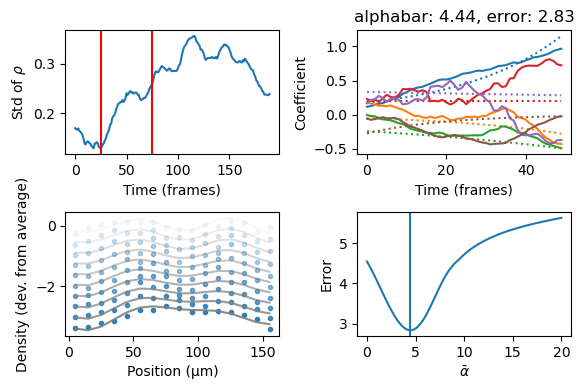

In [23]:
#### Test
fit_alphabar('20240320', '3',tau=35**2/3, sigma=35, make_figure=True)

In [24]:
##### Perform for all bars. Can do this using multiprocessing, for example, to do this in parallel
from multiprocessing import Pool

def fitalphabar_forpool(xx):
    """ xx is a tuple of (experiment, bar)"""
    return fit_alphabar(xx[0], xx[1], tau=35**2 / 3, sigma=35, make_figure=False)

bars_to_fit = allbardata.index
with Pool(10) as p:
    allobs = p.map(fitalphabar_forpool, bars_to_fit)

#### turn the results into a pandas dataframe
minalphabar, minerror, fstart, fend, nmodes, std_start, std_end, rho_start, rho_end, rho_avg = zip(*allobs)
df_alphabar = pd.DataFrame({'alphabar':minalphabar, 'error': minerror,'fstart': fstart, 'fend': fend, 'nmodes': nmodes,
                           'std_start': std_start, 'std_end': std_end, 'rho_start': rho_start, 'rho_end': rho_end, \
                            'rho_avg': rho_avg}, 
                           index=bars_to_fit)
#########
# save
df_alphabar.to_csv("data/data_bar_fitalphabar.csv")

In [25]:
#### TEMP compare to old
fit_old = pd.read_csv("../../data/micropattern_bars/fitted_alphabar_7.csv")
fit_old['Experiment'] = fit_old['Experiment'].astype(str)
fit_old['Bar'] = fit_old['Bar'].astype(str)
fit_old = fit_old.set_index(['Experiment','Bar'])

In [26]:
(df_alphabar['alphabar'] - fit_old['alphabar']).max()

1.7763568394002505e-15

Text(0, 0.5, '$\\bar\\alpha$')

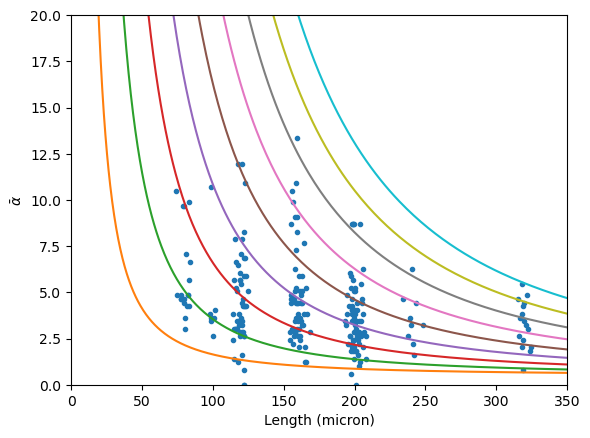

In [33]:
#### Plot the results
df_alphabar['L'] = allbardata['Length_micron']

fig, ax = plt.subplots()
jitter = np.random.normal(size=df_alphabar.shape[0])*3
ax.plot(df_alphabar['L']+jitter, df_alphabar['alphabar'], '.')

##### add the instability lines
for n in range(1, 10):
    xv = np.linspace(n*np.pi, (n+1)*np.pi, 1000)
    zv = (1+np.exp(1j*xv))/(1-np.exp(1j*xv))
    zv = np.hstack((zv, 1/zv))
    xv = np.hstack((xv, xv))
    Lv = (1j*xv/zv).real
    Lv[Lv<0] = np.nan
    av = 0.5*(-zv**2+1)
    l, = ax.plot(Lv*35,av, label='$n={}$'.format(n))
ax.set_ylim(0, 20)
ax.set_xlim(0, 350)
ax.set_xlabel('Length (micron)')
ax.set_ylabel(r'$\bar\alpha$')